In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:41:38.930623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:41:40.513768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 4680
end_idx = 4850
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(170, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(170, 96, 7)
(114240,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(170, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(170, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:41:49.946344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:41:52.966370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 5ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step
CPU time: 3297.7863997931127 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

6/6 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.93395689 0.79279469 0.98779603 ... 0.19838131 0.02801031 0.60641477]
Fitness value of the best solution = 0.008203657506468847


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

6/6 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


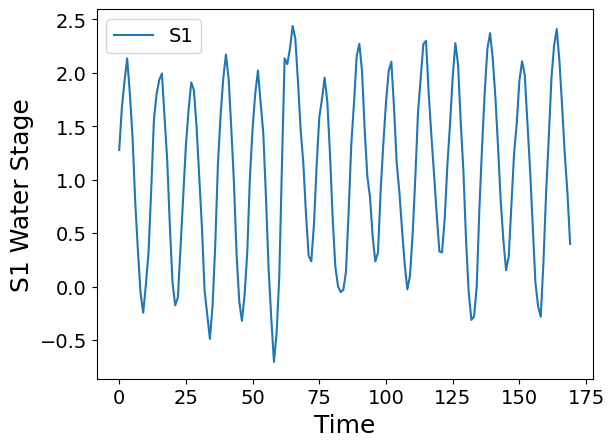

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low7.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.933957,0.792795,0.987796,0.929265,0.495807,0.753538,0.084014,0.700857,0.312328,0.688187,...,0.937950,0.469333,0.177716,0.297963,0.067993,0.317728,0.080598,0.019948,0.434532,0.222594
1,0.307892,0.941390,0.541530,0.983568,0.947007,0.750628,0.853969,0.612372,0.505175,0.695763,...,0.545493,0.178474,0.129828,0.405806,0.002008,0.271330,0.904458,0.606891,0.801545,0.637655
2,0.914196,0.111531,0.657540,0.498796,0.237646,0.668652,0.094385,0.574753,0.856010,0.915818,...,0.168813,0.985052,0.062972,0.540501,0.879141,0.830723,0.220432,0.017495,0.358139,0.699679
3,0.205506,0.934756,0.762265,0.754599,0.513800,0.132366,0.623693,0.714119,0.479901,0.452522,...,0.141075,0.649396,0.264766,0.500992,0.461029,0.709864,0.295023,0.370562,0.930745,0.690213
4,0.579386,0.515708,0.408230,0.878286,0.690015,0.035857,0.645385,0.172704,0.022227,0.722180,...,0.777513,0.165552,0.840857,0.683775,0.990637,0.372313,0.989236,0.150074,0.771243,0.139164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,0.593426,0.578458,0.818836,0.753208,0.477996,0.036871,0.312340,0.240150,0.920585,0.450262,...,0.016043,0.043589,0.787528,0.308433,0.488225,0.042649,0.923186,0.790628,0.147799,0.742732
166,0.749900,0.803709,0.923084,0.115430,0.374108,0.400695,0.230461,0.267625,0.250216,0.481437,...,0.958083,0.164769,0.546850,0.748092,0.025835,0.091274,0.943610,0.411193,0.652244,0.402550
167,0.617288,0.687803,0.676233,0.052095,0.212026,0.705697,0.874616,0.235541,0.892963,0.465174,...,0.944684,0.703000,0.797516,0.225250,0.897756,0.288988,0.736661,0.372838,0.429102,0.801247
168,0.261046,0.324089,0.873641,0.204747,0.417048,0.429343,0.550560,0.376932,0.601123,0.777724,...,0.000931,0.370661,0.492017,0.757708,0.282452,0.806561,0.082092,0.109332,0.067395,0.370695


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low7.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.277794,1.494351,1.241636,1.320426,1.727504,1.863457,1.646952,1.776499,2.008993,1.792609,...,0.035640,-0.049678,-0.062689,0.147010,0.051118,0.008603,0.148919,0.175724,0.123303,0.197568
1,1.674448,1.770317,1.621346,1.741267,2.037400,1.896257,1.972752,2.122028,1.956885,1.745678,...,-0.045727,-0.158062,0.126754,0.411527,0.182685,0.198374,0.591658,0.621402,0.692585,0.793125
2,1.925910,1.819973,1.921740,2.017704,2.052227,2.017331,2.037129,2.168201,1.782288,1.664367,...,0.278707,0.262746,0.667098,0.732388,0.728365,0.799309,1.079955,1.214961,1.143433,1.223561
3,2.136267,2.235226,2.201745,2.310587,1.796054,1.993251,1.800402,1.824501,1.447219,1.401861,...,0.787092,0.751644,1.121917,1.253305,1.065703,1.197492,1.506254,1.612323,1.484649,1.642734
4,1.802371,1.672020,1.837719,1.856113,1.335506,1.362447,1.351565,1.431821,0.831472,0.695627,...,1.091817,1.248483,1.492611,1.440444,1.416365,1.612892,1.758811,1.872117,1.780242,1.942836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2.108026,2.395247,2.202260,2.230801,1.839902,1.808221,1.860890,2.031680,1.299971,1.066444,...,1.349424,1.497741,1.702210,1.871089,1.509148,1.745112,2.137773,2.091234,1.992422,2.275795
166,1.692726,1.812897,1.789987,1.787508,1.366582,1.545549,1.380013,1.497746,0.941072,0.874979,...,1.596727,1.840194,2.108840,1.941824,1.976529,2.233312,2.214205,2.255371,2.119994,2.389177
167,1.238721,1.589704,1.274105,1.244814,0.875180,0.791882,0.856928,0.862811,0.379946,0.672013,...,2.049657,2.292192,2.359534,2.409424,2.316193,2.527949,2.039029,2.040742,2.011263,2.204998
168,0.880180,1.013851,0.970808,0.923371,0.437630,0.640236,0.385385,0.375286,0.286091,0.203998,...,2.202848,2.417102,1.988405,1.993055,2.021777,2.152502,1.655035,1.718573,1.619496,1.781812


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 1171, areas: 204.72641751286574


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

6/6 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 2682, areas: 727.9989976851357
